# 와린이를 위한 추천 시스템
-사용자의 선호도 (분위기, 과일향, 음식취향 등) 선택 시, 와인 리뷰 텍스트의 유사도가 높은 와인을 추천

- dataset : https://www.kaggle.com/datasets/zynicide/wine-reviews?select=winemag-data_first150k.csv

- 회귀 기반 추천 시스템

- **컬럼 명**<br>
Unnamed: 0 : 아이디 번호 <br>
country : 나라 이름<br>
**description : 리뷰**<br>
designation : 와인의 고유 특성<br>
points : 점수<br>
price : 가격<br>
province : 와인 생산 지역<br>
region_1 : 와인 생산 세부 지역 1<br>
region_2 : 와인 생산 세부 지역 2<br>
taster_name : 리뷰 작성자 이름<br>
taster_twitter_handle : 리뷰 작성자 트위터 아이디<br> 
**title : 와인 이름**<br> 
variety : 와인 종류<br> 
winery : 와이너리(양조장)




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## EDA 

In [2]:
wine = pd.read_csv('./data/archive/winemag-data-130k-v2.csv')
print(wine.shape)
wine.head()


(129971, 14)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
wine.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [4]:
# NaN 값 데이터(열) 삭제
columns = ['country', 'variety']
wine = wine.dropna(subset=columns)

# 수치형 결측치 값은 각 컬럼의 평균을 집어넣는다.
wine_price_mean = wine['price'].mean()
wine['price'] = wine['price'].fillna(wine_price_mean)

# 세부 지역 결측치는 나라이름을 집어넣는다.
wine['region_1'] = wine['region_1'].fillna(wine['country'])
wine['region_2'] = wine['region_2'].fillna(wine['country'])

# 컬럼 삭제
columns = ['Unnamed: 0', 'taster_name', 'taster_twitter_handle']
wine = wine.drop(columns, axis = 1)

wine.info()


<class 'pandas.core.frame.DataFrame'>
Index: 129907 entries, 0 to 129970
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129907 non-null  object 
 1   description  129907 non-null  object 
 2   designation  92454 non-null   object 
 3   points       129907 non-null  int64  
 4   price        129907 non-null  float64
 5   province     129907 non-null  object 
 6   region_1     129907 non-null  object 
 7   region_2     129907 non-null  object 
 8   title        129907 non-null  object 
 9   variety      129907 non-null  object 
 10  winery       129907 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 11.9+ MB


| 영어        | 한국어 설명                                  |
|-------------|---------------------------------------------|
| aromas      | 향, 와인의 향기                              |
| fruit       | 과일, 와인의 과일 풍미                       |
| dry         | 드라이한, 단맛이 없는 와인                   |
| palate      | 입안에서 느껴지는 맛과 질감                  |
| offer       | 제시하다, 와인에서 특정 풍미를 느낄 수 있음    |
| apple       | 사과와 같은 과일 풍미                        |
| citrus      | 시트러스와 같은 과일 풍미                    |
| lemon       | 레몬과 같은 과일 풍미                        |
| peach       | 복숭아와 같은 과일 풍미                      |
| pear        | 배와 같은 과일 풍미                          |
| acidity     | 산도, 신맛의 정도                            |
| ripe        | 잘 익은, 과일 맛이 충분히 성숙한 상태        |
| fruity      | 과일 풍미가 풍부한                           |
| wine        | 와인 자체                                   |
| smooth      | 부드러운, 입안에서 매끄러운 느낌            |
| structure   | 구조감, 와인의 균형과 구성                   |
| firm        | 탄탄한, 구조가 강한                         |
| tannins     | 타닌, 떫은맛을 내는 성분                    |
| juicy       | 과즙이 풍부한 느낌                           |
| red         | 적색 와인                                   |
| white       | 백색 와인                                   |
| berry       | 베리류 풍미                                 |
| blackberry  | 블랙베리 같은 풍미                           |
| raspberry   | 라즈베리 같은 풍미                           |
| black cherry| 블랙 체리 같은 풍미                          |
| flavor      | 풍미, 맛                                    |
| green       | 풋내, 덜 익은 과일 같은 풍미                |
| crisp       | 상쾌한, 산뜻한 맛                           |
| finish      | 마무리, 와인이 입안에서 남는 여운           |
| good        | 좋은 품질을 나타냄                          |
| spicy       | 향신료 풍미                                 |
| spice       | 향신료 풍미                                 |
| dark        | 깊고 진한 느낌                              |
| plum        | 자두 같은 풍미                              |
| fresh       | 신선한                                      |
| bright      | 생동감 있고 활기찬 느낌                     |
| smooth      | 부드러운                                    |
| soft        | 부드러운 질감                               |
| texture     | 와인의 질감                                 |
| touch       | 가벼운 느낌으로 존재하는 맛                 |
| drink       | 마실 준비가 된 상태                         |
| cabernet    | 카베르네 품종                               |
| sauvignon   | 소비뇽 품종                                 |
| chocolate   | 초콜릿 풍미                                 |
| character   | 독특한 성격                                 |
| rich        | 풍부한                                      |
| oak         | 오크통 숙성으로 생긴 풍미                   |
| vanilla     | 바닐라 풍미                                 |
| years       | 숙성에 걸리는 기간                          |
| feel        | 와인에서 느껴지는 감각                      |
| nose        | 와인의 향을 맡았을 때의 느낌                |
| blend       | 블렌딩 와인, 여러 포도 품종이 섞인 것       |
| toast       | 구운 듯한 풍미                              |
| hint        | 미묘한 풍미                                 |
| lead        | 주도하는 맛                                 |
| round       | 둥글고 부드러운 느낌                        |
| light       | 가벼운 와인                                 |
| make        | 특정한 특징을 만들어내는 과정               |
| sweet       | 단맛                                        |
| age         | 숙성                                        |


*와인 페어링을 위한 음식 취향 파악*
- 고기 : 진한 레드와인, 소고기, 양고기, 스테이크, 육즙이 풍부한, 풀바디 레드와인, 탄닌이 풍부, 강한 풍미
	[dry, firm, tannins, red, flavor, dark, cabernet, sauvignon]
- 생선 : 화이트 와인, 산뜻하고  깔끔한 산미, 신선함, 해산물 요리
	[fruit, white, crisp, fresh, bright, touch, sauvignon, light]
- 채소 : 화이트, 라이트레드, 구운 채소, 샐러드, 신선한, 상큼함, 섬세한
	[fruit, white, crisp, fresh, bright, touch, sauvignon, light]


*와인의 향과 맛의 선호도 파악*
- 트로피칼 : 화이트, 열대과일, 파인애플, 망고, 멜론, 달콤하고 풍부한 향
	[fruit, apple, peach, pear, ripe, fruity, smooth, juicy, white, flavor, smooth, soft, sauvignon, rich, round, plum, sweet]
- 시트러스 : 화이트, 감귤류, 레몬, 라임, 자몽, 상쾌한 신맛, 산미가 있어 가볍고 시원한 느낌
	[fruit, citrus, lemon, acidity, fruity, juicy, white, flavor, crisp, green, fresh, bright, touch, sauvignon, light]
- 베리 : 레드, 딸기, 체리, 라즈베리, 블랙베리, 밝고 생기있는 과일향
	[fruit, red, berry, blackberry, raspberry, black cherry, bright, cabernet, sauvignon]
- 향신료 : 레드, 후추, 계피, 정향, 따뜻한 향신료, 깊고 복합적인 맛
	[structure, firm, red, flavor, spicy, spice, dark, character, rich ]


*와인 향 중 꽃과 나무 향에 대한 선호도*
- 장미꽃 : 레드와인, 깊고 강렬한 향
	[structure, firm, red, dark, rich ]
- 제비꽃 : 부드럽고 은은한 플로럴 향, 차분하면서도 풍미있는 꽃향
	[smooth, red, flavor, finish, dark, soft, texture, cabernet, sauvignon, rich, nose]
- 백합 : 화이트와인, 깨끗하고 순수한 느낌, 섬세하고 우아한 향
	[white, crisp, fresh, bright, touch, light ]
- 나무 : 오크 숙성, 바닐라, 토스트, 따뜻한 느낌을 주며 묵직한 맛
	[ dry, structure, firm, red, dark, texture,  cabernet, sauvignon, oak, vanilla, years, feel, toast, lead, age  ]


*와인의 단맛과 쓴맛 선호도 파악*
- 달콤한 초콜릿 : 달콤한 와인, 디저트와인, 포트와인, 달콤하면서도 상쾌한 느낌
	[juicy, crisp, bright, chocolate, sweet, light ]

- 카카오 50% : 중간정도의 단맛과 쓴맛, 미디엄 바디, 달콤함과 쓴맛의 조화
	[smooth, soft, chocolate, hint, sweet ]

- 카카오 100% : 진한 와인, 강한 탄닌, 진한 바디, 풀바디의 레드와인, 떫은맛이 강하고, 고농축된
	[dry, structure, firm, tannins, red, dark, chocolate, lead]


*와인의 산도에 대한 선호도 파악*
- 묵은지 : 미네랄리티가 강한 화이트 와인, 쿰쿰한, 진한거, 강한 구조를 가진 레드와인, 깊고 복잡한 맛
	[dry, structure, firm, tannins, red, white, cabernet, sauvignon, oak, years, age ]

- 신김치 : 산미가 높은 와인, 과일향, 화이트 와인, 상큼하고 매운맛, 과일의 신선함
	[acidity, fruit, lemon, white, green, crisp, fresh, bright, light, age ]

- 조금 익은 김치 : 산미가 약한, 부드러운 레드와인, 미디엄 바디의 화이트 와인,  
	[smooth, plum, soft, round ]


*와인의 바디감과 진한 맛에 대한 선호도 파악*
- 라떼 : 라이트한 와인, 가벼운 바디감, 부드럽고 섬세한 맛, 크리미한 질감
	[smooth, soft, light, round ]

- 에스프레소 : 풀바디 레드와인, 진하고 강렬한 맛, 강한 탄닌과 풍부한 맛, 깊고 진하다
	[dry, structure, firm, tannins, red, dark, rich, character]

- 아메리카노 : 중간정도의 바디감, 진한맛, 미디엄 바디감, 적당히 풍부, 과하지 않은 바디감, 진하고 부드러운
	[dry, smooth, soft, rich, hint, round ]


*와인의 탄닌에 대한 민감도 파악*
- 진하게 우려낸 : 탄닌이 진한 와인, 입안에서 씁쓸하고 강렬한 맛, 고기
	[dry, structure, firm, tannins, red, dark ]

- 적당히 우려낸 : 탄닌 중간 와인, 미디엄 바디의 레드와인, 너무 강하지 않으면서도 충분히 구조감이 있어 균형 잡힌 맛
	[structure, red, dark, smooth, soft, hint,  ]

- 연하게 우려낸 : 탄닌 약한 와인, 라이트 바디의 와인, 부드럽고, 섬세한, 가벼운 음식과 어울린다.
	[smooth, soft, touch, light ]

In [5]:
answers = []
def question1(self):
    question1 = input('''
>> 더 선호하시는 것은 무엇입니까? 
1. 고기
2. 생선
3. 채소
''')
    if question1 == '1':
        answer1 = 'dry', 'firm', 'tannins', 'red', 'flavor', 'dark', 'cabernet', 'sauvignon'
        answers.append(answer1)
    elif question1 == '2':
        answer1 = 'fruit', 'white', 'crisp', 'fresh', 'bright', 'touch', 'sauvignon', 'light'
        answers.append(answer1)
    elif question1 == '3':
        answer1 = 'fruit', 'white', 'crisp', 'fresh', 'bright', 'touch', 'sauvignon', 'light'
        answers.append(answer1)

def question2(self):
    question2 = input('''
    >> 더 선호하시는 것은 무엇입니까? 
    1. 트로피칼
    2. 시트러스
    3. 베리
    4. 향신료
    ''')
    if question2 == '1':
        answer2 = 'fruit', 'apple', 'peach', 'pear', 'ripe', 'fruity','smooth', 'juicy', 'white', 'flavor', 'smooth', 'soft', 'sauvignon', 'rich', 'round', 'plum', 'sweet'
        answers.append(answer2)
    elif question2 == '2':
        answer2 = 'fruit', 'citrus', 'lemon', 'acidity', 'fruity', 'juicy', 'white', 'flavor', 'crisp', 'green', 'fresh', 'bright', 'touch', 'sauvignon', 'light'
        answers.append(answer2)
    elif question2 == '3':
        answer2 = 'fruit', 'red', 'berry', 'blackberry', 'raspberry', 'black cherry', 'bright', 'cabernet', 'sauvignon'
        answers.append(answer2)
    elif question2 == '4':
        answer2 = 'structure', 'firm', 'red', 'flavor', 'spicy', 'spice', 'dark', 'character', 'rich'
        answers.append(answer2)  

def question3(self):
    question3 = input('''
    >> 더 선호하시는 것은 무엇입니까? 
    1. 장미꽃
    2. 제비꽃
    3. 백합
    4. 나무
    ''')
    if question3 == '1':
        answer3 = 'structure', 'firm', 'red', 'dark', 'rich'
        answers.append(answer3)
    elif question3 == '2':
        answer3 = 'smooth', 'red', 'flavor', 'finish', 'dark', 'soft', 'texture', 'cabernet', 'sauvignon', 'rich', 'nose'
        answers.append(answer3)
    elif question3 == '3':
        answer3 = 'white', 'crisp', 'fresh', 'bright', 'touch', 'light' 
        answers.append(answer3)
    elif question3 == '4':
        answer3 = 'dry', 'structure', 'firm', 'red', 'dark', 'texture',  'cabernet', 'sauvignon', 'oak', 'vanilla', 'years', 'feel', 'toast', 'lead', 'age'
        answers.append(answer3) 
        
def question4(self):
    question4 = input('''
    >> 더 선호하시는 것은 무엇입니까? 
    1. 달콤한 초콜릿
    2. 카카오 50%
    3. 카카오 100%
    ''')
    if question4 == '1':
        answer4 = 'juicy', 'crisp', 'bright', 'chocolate', 'sweet', 'light'
        answers.append(answer4)
    elif question4 == '2':
        answer4 = 'smooth', 'soft', 'chocolate', 'hint', 'sweet'
        answers.append(answer4)
    elif question4 == '3':
        answer4 = 'dry', 'structure', 'firm', 'tannins', 'red', 'dark', 'chocolate', 'lead'
        answers.append(answer4)

def question5(self):
    question5 = input('''
    >> 어떤 김치를 더 좋아하세요? 
    1. 묵은지
    2. 신김치
    3. 조금 익은 김치
    ''')
    if question5 == '1':
        answer5 = 'dry', 'structure', 'firm', 'tannins', 'red', 'white', 'cabernet', 'sauvignon', 'oak', 'years', 'age'
        answers.append(answer5)
    elif question5 == '2':
        answer5 = 'acidity', 'fruit', 'lemon', 'white', 'green', 'crisp', 'fresh', 'bright', 'light', 'age'
        answers.append(answer5)
    elif question5 == '3':
        answer5 = 'smooth', 'plum', 'soft', 'round'
        answers.append(answer5)
        
def question6(self):
    question6 = input('''
    >> 좋아하는 커피 종류를 알려주세요. 
    1. 라떼
    2. 에스프레소
    3. 아메리카노
    ''')
    if question6 == '1':
        answer6 = 'smooth', 'soft', 'light', 'round'
        answers.append(answer6)
    elif question6 == '2':
        answer6 = 'dry', 'structure', 'firm', 'tannins', 'red', 'dark', 'rich', 'character'
        answers.append(answer6)
    elif question6 == '3':
        answer6 = 'dry', 'smooth', 'soft', 'rich', 'hint', 'round'
        answers.append(answer6)      
        
def question7(self):
    question7 = input('''
    >> 홍차의 떫은 맛에 더 익숙한가요?
    1. 진하게 우려낸
    2. 적당히 우려낸
    3. 연하게 우려낸
    ''')
    if question7 == '1':
        answer7 = 'dry', 'structure', 'firm', 'tannins', 'red', 'dark'
        answers.append(answer7)
    elif question7 == '2':
        answer7 = 'structure', 'red', 'dark', 'smooth', 'soft', 'hint'
        answers.append(answer7)
    elif question7 == '3':
        answer7 = 'smooth', 'soft', 'touch', 'light'
        answers.append(answer7)         
        
def questions(self):
    question1(answers)
    question2(answers)
    question3(answers)
    question4(answers)
    question5(answers)
    question6(answers)
    question7(answers)
    return answers


In [6]:
my_wine = questions(answers)
my_wine

[('dry', 'firm', 'tannins', 'red', 'flavor', 'dark', 'cabernet', 'sauvignon'),
 ('fruit',
  'apple',
  'peach',
  'pear',
  'ripe',
  'fruity',
  'smooth',
  'juicy',
  'white',
  'flavor',
  'smooth',
  'soft',
  'sauvignon',
  'rich',
  'round',
  'plum',
  'sweet'),
 ('white', 'crisp', 'fresh', 'bright', 'touch', 'light'),
 ('juicy', 'crisp', 'bright', 'chocolate', 'sweet', 'light'),
 ('smooth', 'plum', 'soft', 'round'),
 ('dry', 'smooth', 'soft', 'rich', 'hint', 'round'),
 ('smooth', 'soft', 'touch', 'light')]

In [7]:
result = [", ".join(item) for item in my_wine]
final_result = "\n".join(result)
print(final_result)

user_input = [None, final_result, None, None, None, None, None, None, None, None, None]
wine.loc[129971] = user_input
wine['description'][::-1]

dry, firm, tannins, red, flavor, dark, cabernet, sauvignon
fruit, apple, peach, pear, ripe, fruity, smooth, juicy, white, flavor, smooth, soft, sauvignon, rich, round, plum, sweet
white, crisp, fresh, bright, touch, light
juicy, crisp, bright, chocolate, sweet, light
smooth, plum, soft, round
dry, smooth, soft, rich, hint, round
smooth, soft, touch, light


C:\Users\playdata2\AppData\Local\Temp\ipykernel_3368\2782508465.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wine.loc[129971] = user_input


129971    dry, firm, tannins, red, flavor, dark, caberne...
129970    Big, rich and off-dry, this is powered by inte...
129969    A dry style of Pinot Gris, this is crisp with ...
129968    Well-drained gravel soil gives this wine its c...
129967    Citation is given as much as a decade of bottl...
                                ...                        
4         Much like the regular bottling from 2012, this...
3         Pineapple rind, lemon pith and orange blossom ...
2         Tart and snappy, the flavors of lime flesh and...
1         This is ripe and fruity, a wine that is smooth...
0         Aromas include tropical fruit, broom, brimston...
Name: description, Length: 129908, dtype: object

## NLTK

In [8]:
# !conda install nltk -y

In [28]:
import nltk
import string
nltk.__version__

'3.9.1'

### TfidfVectorizer

In [29]:
from nltk.stem import WordNetLemmatizer

def lemmatize(text):
    """
    소문자변환, 특수문자제거, 토큰화, 어근분리
    """
    # 1. 소문자 변환
    text = text.lower() 
    
    # 2. 특수문자 변환표 dict
    punc_rem_dict = dict((ord(ch), None) for ch in string.punctuation)
    text = text.translate(punc_rem_dict) # 특수문자 제거  
    
    # 3. 토큰화 
    tokens = nltk.word_tokenize(text)
    
    # 4. 어근분리 
    lemmatizer = WordNetLemmatizer()
    
    return [lemmatizer.lemmatize(token, pos='v') for token in tokens]


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=lemmatize,
    stop_words='english',
    ngram_range=(1, 2),
    max_df = 0.9,
    min_df = 0.05
)
review_vecs = tfidf_vectorizer.fit_transform(wine['description'])
print(review_vecs.toarray().shape)  # 밀집행렬
print(review_vecs)  # 희소행렬


C:\Users\playdata2\anaconda3\envs\ml_env\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\playdata2\anaconda3\envs\ml_env\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn(


(129908, 66)
  (0, 3)	0.24203050040597396
  (0, 26)	0.211075224277132
  (0, 20)	0.6045686800381042
  (0, 41)	0.247306277029237
  (0, 39)	0.34288352637529024
  (0, 2)	0.3743479700023509
  (0, 15)	0.38257686653873735
  (0, 0)	0.2571657615497847
  (1, 26)	0.183135732509644
  (1, 0)	0.2231253823328174
  (1, 49)	0.2511868634115339
  (1, 27)	0.3470393693114256
  (1, 64)	0.16446314802683093
  (1, 52)	0.37130515651022467
  (1, 56)	0.3196138538013565
  (1, 23)	0.3500004599464443
  (1, 58)	0.235480244162313
  (1, 31)	0.34369045138959387
  (1, 47)	0.2901805233622492
  (1, 5)	0.29291195147010335
  (2, 0)	0.3484648331976187
  (2, 64)	0.2568494128509367
  (2, 24)	0.5065471954414017
  (2, 29)	0.5554169280155726
  (2, 17)	0.4975164459662412
  :	:
  (129907, 27)	0.09621519262551859
  (129907, 52)	0.5147138958234531
  (129907, 23)	0.09703614243993079
  (129907, 58)	0.0652858985323057
  (129907, 31)	0.19057343868283994
  (129907, 47)	0.08045131884278525
  (129907, 24)	0.08992384018026389
  (129907, 17)	0

In [31]:
# 66개의 단어 
tfidf_vectorizer.vocabulary_


{'aromas': 3,
 'fruit': 26,
 'dry': 20,
 'palate': 41,
 'offer': 39,
 'apple': 2,
 'citrus': 15,
 'acidity': 0,
 'ripe': 49,
 'fruity': 27,
 'wine': 64,
 'smooth': 52,
 'structure': 56,
 'firm': 23,
 'tannins': 58,
 'juicy': 31,
 'red': 47,
 'berry': 5,
 'flavor': 24,
 'green': 29,
 'crisp': 17,
 'lemon': 33,
 'note': 37,
 'finish': 22,
 'come': 16,
 'good': 28,
 'blackberry': 8,
 'raspberry': 46,
 'spicy': 55,
 'dark': 18,
 'plum': 45,
 'fresh': 25,
 'bright': 10,
 'open': 40,
 'white': 63,
 'pepper': 44,
 'balance': 4,
 'soft': 53,
 'spice': 54,
 'texture': 59,
 'peach': 42,
 'pear': 43,
 'touch': 61,
 'drink': 19,
 'cabernet': 11,
 'chocolate': 14,
 'character': 12,
 'rich': 48,
 'black': 6,
 'cherry': 13,
 'oak': 38,
 'black cherry': 7,
 'vanilla': 62,
 'years': 65,
 'feel': 21,
 'nose': 36,
 'blend': 9,
 'sauvignon': 51,
 'toast': 60,
 'hint': 30,
 'lead': 32,
 'round': 50,
 'light': 34,
 'make': 35,
 'sweet': 57,
 'age': 1}

## KMeans 군집화

In [32]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters = 10,
    max_iter = 10000,
    random_state = 0
)
# 중심점 게산
reviews_label = kmeans.fit_predict(review_vecs)
wine['cluster'] = reviews_label
wine[::-1]


,country,description,designation,points,price,province,region_1,region_2,title,variety,winery,cluster
129971,None,"dry, firm, tannins, red, flavor, dark, caberne...",None,None,NaN,None,None,None,None,None,None,1
129970,France,"Big, rich and off-dry, this is powered by inte...",Lieu-dit Harth Cuvée Caroline,90,21.000000,Alsace,Alsace,France,Domaine Schoffit 2012 Lieu-dit Harth Cuvée Car...,Gewürztraminer,Domaine Schoffit,8
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.000000,Alsace,Alsace,France,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,2
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.000000,Alsace,Alsace,France,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.000000,Oregon,Oregon,Oregon Other,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,2
...,...,...,...,...,...,...,...,...,...,...,...,...
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,8
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,US,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,9
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.000000,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,8
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,Portugal,Portugal,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2


In [33]:
# 클러스터별 샘플 확인
wine[wine['cluster'] == 0]


,country,description,designation,points,price,province,region_1,region_2,title,variety,winery,cluster
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,0
18,Spain,"Desiccated blackberry, leather, charred wood a...",Vendimia Seleccionada Finca Valdelayegua Singl...,87,28.0,Northern Spain,Ribera del Duero,Spain,Pradorey 2010 Vendimia Seleccionada Finca Vald...,Tempranillo Blend,Pradorey,0
25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa,0
38,Italy,"Inky in color, this wine has plump aromas of r...",I Tratturi,86,11.0,Southern Italy,Puglia,Italy,Feudi di San Marzano 2011 I Tratturi Primitivo...,Primitivo,Feudi di San Marzano,0
68,US,"Very deep in color and spicy-smoky in flavor, ...",NaN,86,12.0,California,California,California Other,Cocobon 2014 Red (California),Red Blend,Cocobon,0
...,...,...,...,...,...,...,...,...,...,...,...,...
129870,Spain,"Cool, minty aromas of blueberry and blackberry...",NaN,90,45.0,Northern Spain,Ribera del Duero,Spain,Bodegas y Viñedos Tábula 2014 Ribera del Duero,Tempranillo,Bodegas y Viñedos Tábula,0
129887,Argentina,"Earthy balsamic aromas of cheesy oak, blackber...",One Doña Angeles Vineyard,91,88.0,Mendoza Province,Mendoza,Argentina,Antigal 2010 One Doña Angeles Vineyard Malbec ...,Malbec,Antigal,0
129917,Argentina,"This dark, meaty Malbec has some Agrelo fruit ...",Piedra Negra,91,40.0,Mendoza Province,Mendoza,Argentina,J. & F. Lurton 2004 Piedra Negra Malbec (Mendoza),Malbec,J. & F. Lurton,0
129942,US,This is classic in herbaceous aromas and flavo...,NaN,90,35.0,California,Sonoma County,Sonoma,Arrowood 2010 Cabernet Sauvignon (Sonoma County),Cabernet Sauvignon,Arrowood,0


In [34]:
# 군집화 중심점
centers = kmeans.cluster_centers_
centers.shape # (클러스터 개수, 단어개수)


(10, 66)

In [35]:
# tf-idf값이 높은 순으로 정렬
centroid_arg_ind = centers.argsort()[:, ::-1]
top20 = centroid_arg_ind[:, :30]
feature_names = tfidf_vectorizer.get_feature_names_out()
display(feature_names[top20])

top20_df = pd.DataFrame(feature_names[top20])
display(top20_df)

array([['blackberry', 'flavor', 'tannins', 'wine', 'finish', 'chocolate',
        'aromas', 'ripe', 'drink', 'dry', 'black', 'rich', 'dark',
        'palate', 'fruit', 'oak', 'spice', 'note', 'cherry', 'plum',
        'pepper', 'soft', 'good', 'years', 'cabernet', 'nose', 'make',
        'blend', 'offer', 'firm'],
       ['light', 'wine', 'flavor', 'fruit', 'acidity', 'fresh', 'crisp',
        'drink', 'fruity', 'finish', 'aromas', 'red', 'palate',
        'texture', 'bright', 'touch', 'soft', 'citrus', 'dry', 'nose',
        'cherry', 'spice', 'note', 'apple', 'make', 'offer', 'tannins',
        'character', 'balance', 'lemon'],
       ['wine', 'age', 'fruit', 'structure', 'tannins', 'drink', 'firm',
        'ripe', 'years', 'rich', 'acidity', 'black', 'character', 'dark',
        'flavor', 'dry', 'juicy', 'balance', 'red', 'texture', 'spice',
        'berry', 'come', 'fruity', 'good', 'smooth', 'plum', 'blend',
        'fresh', 'make'],
       ['oak', 'flavor', 'fruit', 'wine', 'fini

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,blackberry,flavor,tannins,wine,finish,chocolate,aromas,ripe,drink,dry,...,pepper,soft,good,years,cabernet,nose,make,blend,offer,firm
1,light,wine,flavor,fruit,acidity,fresh,crisp,drink,fruity,finish,...,cherry,spice,note,apple,make,offer,tannins,character,balance,lemon
2,wine,age,fruit,structure,tannins,drink,firm,ripe,years,rich,...,spice,berry,come,fruity,good,smooth,plum,blend,fresh,make
3,oak,flavor,fruit,wine,finish,vanilla,toast,aromas,note,palate,...,make,berry,balance,black,red,plum,spicy,nose,raspberry,good
4,aromas,flavor,berry,finish,cherry,palate,red,note,fruit,spice,...,acidity,hint,blend,lead,bright,vanilla,chocolate,fresh,pepper,open
5,cabernet,sauvignon,blend,flavor,wine,fruit,tannins,black,finish,cherry,...,dark,plum,oak,offer,ripe,berry,soft,rich,balance,structure
6,black,black cherry,cherry,tannins,palate,pepper,aromas,fruit,wine,spice,...,berry,red,open,firm,raspberry,blackberry,chocolate,juicy,hint,make
7,sweet,flavor,wine,fruit,finish,acidity,ripe,soft,aromas,vanilla,...,make,raspberry,tannins,good,nose,blackberry,red,berry,blend,feel
8,wine,acidity,fruit,drink,flavor,ripe,crisp,texture,fruity,rich,...,citrus,finish,touch,round,smooth,blend,spicy,toast,hint,tannins
9,apple,palate,citrus,white,peach,finish,lemon,pear,flavor,aromas,...,crisp,bright,ripe,touch,make,balance,drink,round,open,lead


In [36]:
# 와인 이름 관련 리뷰를 기준 리뷰로 선정
# 마지막 리뷰(사용자 지정 데이터)를 기준 리뷰로 선정
base_index = 129971
wine.loc[base_index]


country                                                     None
description    dry, firm, tannins, red, flavor, dark, caberne...
designation                                                 None
points                                                      None
price                                                        NaN
province                                                    None
region_1                                                    None
region_2                                                    None
title                                                       None
variety                                                     None
winery                                                      None
cluster                                                        1
Name: 129971, dtype: object

In [37]:
# 기준 리뷰와 모든 리뷰의 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

print(review_vecs[-1].shape, review_vecs.shape)  # (1, 66) (129908, 66)

review_sim = cosine_similarity(review_vecs[-1], review_vecs)
print(review_sim.shape)


(1, 66) (129908, 66)
(1, 129908)


In [38]:
# 유사도가 높은 순으로 정렬
review_sorted_index = review_sim.argsort()[:, ::-1]  # 내림차순 정렬
review_sorted_index = review_sorted_index[:, 1:]
review_sorted_index = review_sorted_index.reshape(-1)  # 자기자신 제외
print(review_sorted_index.shape)

# 유사도가 높은 순으로 정렬된 와인 이름 조회
result_df = wine.iloc[review_sorted_index][['title', 'cluster']]
review_sim = review_sim.reshape(-1)
result_df['similarity'] = review_sim[review_sorted_index]


(129907,)


In [48]:
top15 = result_df.head(15)
top15


,title,cluster,similarity
96355,Judd's Hill 2012 Estate Cabernet Sauvignon (Na...,1,0.694137
105812,Jean-Luc and Paul Aegerter 2013 Pinot Noir (Pa...,1,0.683490
82931,Barão de Vilar NV Tawny Reserve Decanter (Port),7,0.665827
94707,Château de Brigue 2011 Signature Rosé (Côtes d...,1,0.659227
50961,Château de Brigue 2011 Signature Rosé (Côtes d...,1,0.659227
78975,Closerie du Bailli 2013 Tradition Rosé (Bordea...,8,0.658785
12819,Château Rimauresq 2014 Rimauresq Rosé (Côtes d...,8,0.651310
110446,Château Rimauresq 2014 Rimauresq Rosé (Côtes d...,8,0.651310
67478,David Hill 2013 Estate Reserve Chardonnay (Wil...,1,0.650974
74541,I Giusti e Zanza 1999 Belcore Sangiovese (Tosc...,7,0.649227


In [51]:
wine['description'][113922]


"Deeply colored and pretty full-bodied, this Rhône blend has off-flavors that are medicinal and vegetative. It's just barely drinkable."

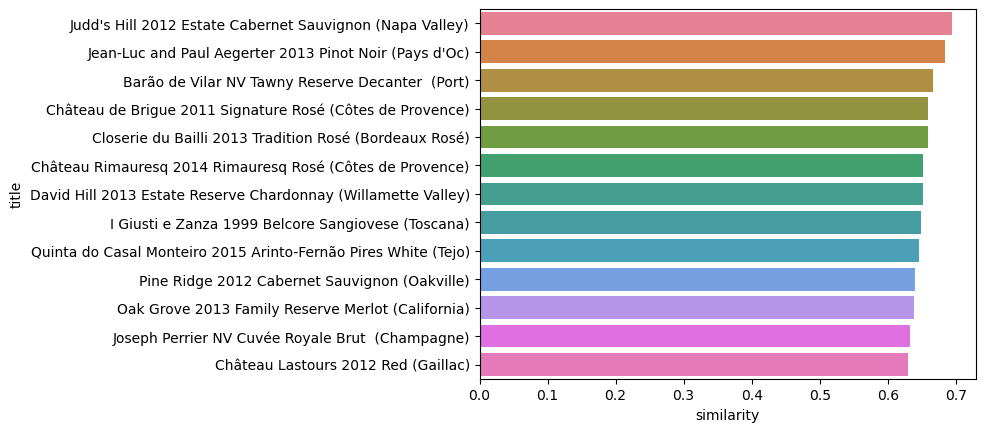

In [49]:
sns.barplot(x = 'similarity', y = 'title', data = top15, hue = 'title')

plt.show()

In [50]:
bottom15 = result_df.iloc[::-1].head(15)
bottom15

,title,cluster,similarity
113922,Eric Ross 2007 Saralee's Vineyard Marsanne-Rou...,5,0.0
60473,Proulx 2012 Pinot Noir (Central Coast),4,0.0
60487,29 & Oak Wines 2014 Zinfandel (Oakville),8,0.0
60562,Marchesi de' Frescobaldi 2003 Castello di Pomi...,4,0.0
19624,"Lee Family Farm 2009 Rio Tinto, Silvaspoons Vi...",8,0.0
19615,Di Meo 2005 Colle dei Cerri (Fiano di Avellino),4,0.0
60660,Decoy 2015 Sauvignon Blanc (Sonoma County),8,0.0
115812,Jardin 2004 Nine Yards Chardonnay (Stellenbosch),9,0.0
115810,Dobbes Family Estate 2005 Cuvée Noir Pinot Noi...,4,0.0
3791,V. Sattui 2012 Carsi Vineyard Chardonnay (Napa...,3,0.0
